# Merge the prophage predictions with RAST metadata

Combine RAST metadata and prophage predictions

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison
from statsmodels.multivariate.manova import MANOVA
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier

# for parsing collection dates
from dateutil.parser import parse
from datetime import datetime
import pytz

import subprocess
import gzip


In [2]:
# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

### Date conversion

This routine is used to convert the dates into something useable. Here we choose a point in time (i.e. Feb 24, 1977) and set all dates to be relative to that. We use years as our unit, but could also use seconds. ([Hint](https://pubmed.ncbi.nlm.nih.gov/870828/))


In [3]:
# Convert the collection date to a number. We take todays date, and then convert relative to that
# it allows dates pre-epoch

yr = re.compile("^[~]*(\d{4})['s]*$")
yrrange = re.compile("^(\d{4})\s*.\s*(\d{4})$")
myd = re.compile('^\d{1,4}/\d{1,2}/\d{1,4}$')
damoyrrange = re.compile('^(\d+\s+\w+\s+\d{4})\s*.{1,3}?\s*(\d+\s+\w+\s+\d{4})$')
modacyrrange = re.compile('^(\w+\s+\d+,*\s+\d{4})\s*.{1,3}?\s*(\w+\s+\d+,*\s+\d{4})$')
moyrrange = re.compile('^(\w+\s+\d{4})\s*.{1,3}?\s*(\w+\s+\d{4})$')
year42 = re.compile('^(\d{4})-\d{2}$')
lem = re.compile("^late\s*|^early\s*|^mid\s*|^prior to\s*|^before\s*|^pre-", re.IGNORECASE)
splitseen = set()
adate = parse("24/02/1977")
adate = adate.replace(tzinfo=pytz.UTC)

def try_parsing(x):
    """
    Attempt to parse a date, and catch an error.
    
    If we fail, we return None, otherwise we return the years since now()
    """
    try:
        dt = parse(x)
    except:
        return None
    
    dt = dt.replace(tzinfo=pytz.UTC)
    
    if dt < adate:
        tdelt = adate - dt
        seconds = -1 * ((tdelt.days * 86400) + tdelt.seconds)
    else:
        tdelt = dt - adate
        seconds = (tdelt.days * 86400) + tdelt.seconds
    # convert seconds to years
    return seconds/31557600 
    

def convert_date_too(x):
    """
    Convert the date to years and fractions.
    
    We try several times, and clean it up as we go along.    
    """
    if pd.isna(x):
        return np.nan

    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        return attempt
    orix = x
    
    if x.lower() in ['restricted access', 'none', 'not collected', 'not applicable', 'not available: not collected', 'unspecified']:
        return np.nan
   
    # a few one off cases that are just easier to fix
    if 'May 2015-Nov 2015' == x:
        x = 'May 2015'
    
    if '1954-65' == x:
        x = '01 January 1954'
        
    if 'Jul-00' == x:
        x = 'Jul-2000'

    if '2015_9' == x:
        x = 'Sep-2015'
    
    if '31-Mac-2013' == x:
        x = '31-May-2013'
    
    if '2010-0916' == x:
        x = '16 Sep 2010'
     
    x = lem.sub('', x)
    
        
    if '_' in x:
        x = x.replace('_', '-')
        
    x = x.replace(' or earlier', '')
    x = x.replace('collected in the ', '')
        
    # some regular expressions of variants of day month year - day month year ranges. We choose 1
    m = yrrange.match(x)
    if m:
        x = '01 January ' + m.groups()[1]

    m = yr.match(x)
    if m:
        x = '01 January ' + m.groups()[0]

    m = year42.match(x)
    if m:
        x = '01 January ' + m.groups()[0]
            
    m = modacyrrange.match(x)
    if m:
        x = m.groups()[1]
        
    m = damoyrrange.match(x)
    if m:
        x = m.groups()[1]
    
    m = moyrrange.match(x)
    if m:
        x = '01 ' + m.groups()[1]
        
    
        
    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        return attempt
          
    if '/' in x:
        if x not in splitseen:
            # sys.stderr.write(f"Splitting {x}\n")
            splitseen.add(x)
        p = x.split('/')
        x = p[1]
   
    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        return attempt
   
    if x.endswith('-00'):
        x = x.replace('-00', '-2000')

    # can we parse this date? If so, lets do it and return the value
    attempt = try_parsing(x)
    if attempt:
        return attempt

    
    sys.stderr.write(f"can't parse |{x}| from |{orix}|\n")
            
    return np.nan

### Read the data file

The metadata is from PATRIC. The phage data is from us.

**NOTE:** Some of the PATRIC data refers to specific chromosomes/fragments in the GenBank file (e.g. plasmid, chromosome), but that may not equate to our predictions, because we have used the whole GenBank file. The PATRIC metadata is redundant for many fields, and so we just keep the first entry for each NCBI Assembly.

In [4]:
# the full data set. Don't try this at home!
# metadf = pd.read_csv("../small_data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
metadf = pd.read_csv("../data/patric_genome_metadata.tsv.gz", compression='gzip', header=0, delimiter="\t")
metadf['years_ago'] = metadf.collection_date.apply(convert_date_too)
metadf

/home/redwards/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,6,7,8,9,10,11,12,14,19,21,34,40,41,42,43,44,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,65) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
can't parse |1999 and 2000| from |1999 and 2000|
can't parse |0-Apr-2008| from |0-Apr-2008|
can't parse |CGMCC No.5392| from |CGMCC No.5392|
can't parse |CGMCC No.5392| from |CGMCC No.5392|


,genome_id,genome_name,organism_name,taxon_id,genome_status,strain,serovar,biovar,pathovar,mlst,...,sporulation,temperature_range,optimal_temperature,salinity,oxygen_requirement,habitat,disease,comments,additional_metadata,years_ago
0,469009.4,"""'Brassica napus' phytoplasma strain TW1""",NaN,469009,WGS,TW1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Genome sequence of a strain of bacteria that c...,sample_type:metagenomic assembly;collected_by:...,40.470910
1,1309411.5,"""'Deinococcus soli' Cha et al. 2014 strain N5""",NaN,1309411,Complete,N5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Genome sequencing of a Gamma-Radiation-Resista...,sample_type:bacterial,36.114990
2,1123738.3,"""'Echinacea purpurea' witches'-broom phytoplas...",NaN,1123738,WGS,NCHU2014,NaN,NaN,NaN,NaN,...,NaN,NaN,C,NaN,NaN,NaN,NaN,'Echinacea purpurea' witches'-broom phytoplasm...,lab_host:Catharanthus roseus,37.264887
3,551115.6,"""'Nostoc azollae' 0708""",'Nostoc azollae' 0708,551115,Complete,708,NaN,NaN,NaN,NaN,...,NaN,Mesophilic,-,NaN,Aerobic,Multiple,NaN,"Nostoc azollae 0708. Nostoc azollae 0708, also...",NaN,NaN
4,1856298.3,"""'Osedax' symbiont bacterium Rs2_46_30_T18 str...",NaN,1856298,WGS,Rs2_46_30_T18,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"In this study, we simulate the Deepwater Horiz...",sample_type:metagenomic assembly,36.418891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433517,1131286.3,zeta proteobacterium SCGC AB-137-J06,zeta proteobacterium SCGC AB-137-J06,1131286,WGS,SCGC AB-137-J06,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Single cell genome sequencing of biomineralizi...,NaN,NaN
433518,1131287.3,zeta proteobacterium SCGC AB-602-C20,zeta proteobacterium SCGC AB-602-C20,1131287,WGS,SCGC AB-602-C20,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Single cell genome sequencing of biomineralizi...,NaN,NaN
433519,1131288.3,zeta proteobacterium SCGC AB-602-E04,zeta proteobacterium SCGC AB-602-E04,1131288,WGS,SCGC AB-602-E04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Single cell genome sequencing of biomineralizi...,NaN,NaN
433520,1131289.3,zeta proteobacterium SCGC AB-604-B04,zeta proteobacterium SCGC AB-604-B04,1131289,WGS,SCGC AB-604-B04,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Single cell genome sequencing of biomineralizi...,NaN,NaN


### Make sure we have the right column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [5]:
acccol = 'assembly_accession'
metadf[acccol]

0         GCA_003181115.1
1         GCF_001007995.1
2         GCF_001307505.1
3         GCA_000196515.1
4         GCA_002163025.1
               ...       
433517    GCA_000379245.1
433518    GCA_000379345.1
433519    GCA_000379265.1
433520    GCA_000379205.1
433521    GCA_000372125.1
Name: assembly_accession, Length: 433522, dtype: object

### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [6]:
def get_acc_name(x):
    regexp = re.compile('(\w+\.\d+)_([\w\.\-]+)_genomic.gbff.gz')
    m = regexp.match(x)
    if not m:
        sys.stderr.write(f"WARNING: Regexp did not match {x}\n")
        return (None, None)
    return list(m.groups())

#phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
phagesdf = pd.read_csv("../data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
phagesdf = pd.concat([pd.DataFrame.from_records(phagesdf['Contig'].apply(get_acc_name), columns=[acccol, 'Name']), phagesdf], axis=1)
phagesdf

,assembly_accession,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16,2,1,13,48916
1,GCA_000003645.1,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31,1,10,20,40297
2,GCA_000003925.1,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38,6,13,19,268081
3,GCA_000003955.1,ASM395v1,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46,6,11,29,166286
4,GCA_000005825.2,ASM582v2,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...,...
399577,GCA_902860175.1,LMG_5997,GCA_902860175.1_LMG_5997_genomic.gbff.gz,7197255,21,33,2,14,17,69051
399578,GCA_902860185.1,LMG_6103,GCA_902860185.1_LMG_6103_genomic.gbff.gz,6497464,8,22,0,10,12,0
399579,GCA_902860195.1,LMG_7053,GCA_902860195.1_LMG_7053_genomic.gbff.gz,6702936,148,33,1,11,21,12819
399580,GCA_902860205.1,LMG_6001,GCA_902860205.1_LMG_6001_genomic.gbff.gz,6320373,19,35,2,21,12,41572


### Merge the dataframes

First, select some columns we want to keep from PATRIC, and then merge the data frames. We write this to a tsv file for Laura to append isolation information to.

In [7]:
interesting_cols = [acccol, 'isolation_site', 'isolation_source', 'isolation_comments', 
                    'isolation_country', 'geographic_location', 'latitude', 'longitude', 'altitude', 'depth',
                    'other_environmental', 'host_name', 'host_gender', 'host_age', 'host_health', 
                    'body_sample_site', 'body_sample_subsite', 'other_clinical', 'gram_stain', 'cell_shape',
                    'motility', 'sporulation', 'temperature_range', 'optimal_temperature', 'salinity',
                    'oxygen_requirement', 'habitat', 'disease', 'years_ago']

few_interesting_cols = [acccol,  'isolation_source',  'isolation_country',  'gram_stain',  
                    'motility', 'sporulation', 'temperature_range', 'habitat', 'disease', 'years_ago']


# tempdf = metadf[interesting_cols]
tempdf = metadf[few_interesting_cols]
phagemeta = pd.merge(tempdf, phagesdf, how='right', left_on=acccol, right_on=acccol)
phagemeta.to_csv(os.path.join('results', 'example_isolations.tsv'), sep='\t')

In [8]:
phagemeta

,assembly_accession,isolation_source,isolation_country,gram_stain,motility,sporulation,temperature_range,habitat,disease,years_ago,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,NaN,NaN,+,No,No,Mesophilic,Host-associated,NaN,NaN,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16,2,1,13,48916
1,GCA_000003645.1,cream cheese,NaN,+,Yes,Yes,Mesophilic,Multiple,Food poisoning,NaN,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31,1,10,20,40297
2,GCA_000003925.1,soil,NaN,+,No,Yes,NaN,NaN,NaN,NaN,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38,6,13,19,268081
3,GCA_000003955.1,human blood,Iceland,+,Yes,Yes,Mesophilic,Multiple,Food poisoning,NaN,ASM395v1,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46,6,11,29,166286
4,GCA_000005825.2,soil,United States,NaN,Yes,NaN,Mesophilic,Terrestrial,NaN,NaN,ASM582v2,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403548,GCA_902860175.1,Laboratory sink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.850103,LMG_5997,GCA_902860175.1_LMG_5997_genomic.gbff.gz,7197255,21,33,2,14,17,69051
403549,GCA_902860185.1,Human,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,22.850103,LMG_6103,GCA_902860185.1_LMG_6103_genomic.gbff.gz,6497464,8,22,0,10,12,0
403550,GCA_902860195.1,Human,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,22.850103,LMG_7053,GCA_902860195.1_LMG_7053_genomic.gbff.gz,6702936,148,33,1,11,21,12819
403551,GCA_902860205.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.850103,LMG_6001,GCA_902860205.1_LMG_6001_genomic.gbff.gz,6320373,19,35,2,21,12,41572


In [24]:
#phagemeta.iloc[:,2:29]
phagemeta.iloc[:,1:10]

,isolation_source,isolation_country,gram_stain,motility,sporulation,temperature_range,habitat,disease,years_ago
0,NaN,NaN,+,No,No,Mesophilic,Host-associated,NaN,NaN
1,cream cheese,NaN,+,Yes,Yes,Mesophilic,Multiple,Food poisoning,NaN
2,soil,NaN,+,No,Yes,NaN,NaN,NaN,NaN
3,human blood,Iceland,+,Yes,Yes,Mesophilic,Multiple,Food poisoning,NaN
4,soil,United States,NaN,Yes,NaN,Mesophilic,Terrestrial,NaN,NaN
...,...,...,...,...,...,...,...,...,...
403548,Laboratory sink,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.850103
403549,Human,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,22.850103
403550,Human,United Kingdom,NaN,NaN,NaN,NaN,NaN,NaN,22.850103
403551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.850103


In [10]:
# phagemeta.iloc[:,34:35]
phagemeta.iloc[:,15:16]

,Kept
0,2
1,1
2,6
3,6
4,3
...,...
403548,2
403549,0
403550,1
403551,2


## Encode the data

This converts every column into categories so we can (hopefully) use it in the RF models

In [25]:
pmenc = pd.DataFrame()
#for c in phagemeta.iloc[:,2:28].columns:
for c in phagemeta.iloc[:,1:9].columns:
    pmenc[c] = phagemeta[c].astype('category').cat.codes
pmenc['years_ago'] = phagemeta['years_ago'].fillna(-1)
pmenc.sort_values('years_ago')

,isolation_source,isolation_country,gram_stain,motility,sporulation,temperature_range,habitat,disease,years_ago
78916,2178,101,-1,-1,-1,-1,-1,-1,-157.514031
84232,4789,-1,-1,-1,-1,-1,-1,-1,-93.883641
402183,7499,-1,-1,-1,-1,-1,-1,-1,-91.882272
380373,-1,38,-1,-1,-1,-1,-1,-1,-87.882272
7611,8897,-1,4,5,8,-1,-1,-1,-81.883641
...,...,...,...,...,...,...,...,...,...
402128,4552,191,-1,-1,-1,-1,-1,-1,44.695414
7936,128,144,-1,-1,-1,-1,-1,-1,44.709103
10163,-1,144,-1,-1,-1,-1,-1,-1,44.711841
47315,5800,234,-1,-1,-1,-1,-1,-1,44.717317


In [21]:
phagemeta.loc[78916]

assembly_accession                                       GCA_002899365.1
isolation_source                                               Maize zea
isolation_country                                                  Italy
gram_stain                                                           NaN
motility                                                             NaN
sporulation                                                          NaN
temperature_range                                                    NaN
habitat                                                              NaN
disease                                                              NaN
years_ago                                                    -157.514031
Name                                                         ASM289936v1
Contig                       GCA_002899365.1_ASM289936v1_genomic.gbff.gz
Genome length                                                    5084329
Contigs                                            

In [23]:
metadf[metadf['assembly_accession'] == 'GCA_002899365.1'][['collection_date', 'years_ago']]

,collection_date,years_ago
313151,1819-08-20,-157.514031


## Random Forest

Can we identify which features best predict the number of phages predicted. Note we should compare total/kept/etc

First, an RF with all the data. You might want to skip this!

In [26]:
clf = RandomForestClassifier(random_state=42, n_estimators=100, bootstrap=True, n_jobs=-1, oob_score=True)
rf = clf.fit(pmenc, phagemeta.Kept.values.ravel())
print(rf)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)


## Important features

What are the most important features for predicting the number of prophages in a genome?

In [27]:
fi = pd.DataFrame(zip(pmenc.columns, rf.feature_importances_), columns=['feature', 'importance'])
impdf = fi.sort_values('importance', ascending=False)
impdf

,feature,importance
8,years_ago,0.382053
0,isolation_source,0.374431
1,isolation_country,0.169395
7,disease,0.016868
6,habitat,0.016644
2,gram_stain,0.016056
3,motility,0.009971
5,temperature_range,0.008608
4,sporulation,0.005973


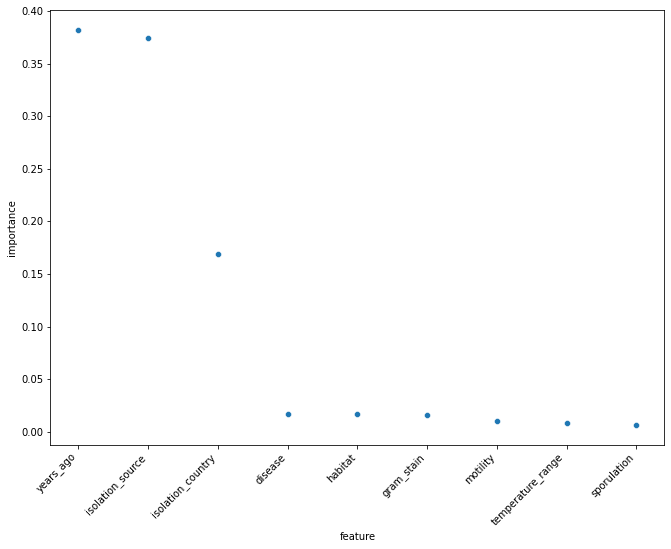

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='feature', y='importance', data=impdf, ax=ax)
plt.xticks(rotation=45,  horizontalalignment='right')
fig.savefig(f"images/rf_importance.svg")

In [29]:
printmd("**Random Forest output**", "blue")
printmd(f"There were {rf.n_features_} _features_ (columns in the dataframe), and {rf.n_classes_} _classes_ (unique categories)")
printmd(f"The OOB error was {rf.oob_score_}")

<span style='color:blue'>**Random Forest output**</span>

<span style='color:black'>There were 9 _features_ (columns in the dataframe), and 56 _classes_ (unique categories)</span>

<span style='color:black'>The OOB error was 0.15956516244458596</span>

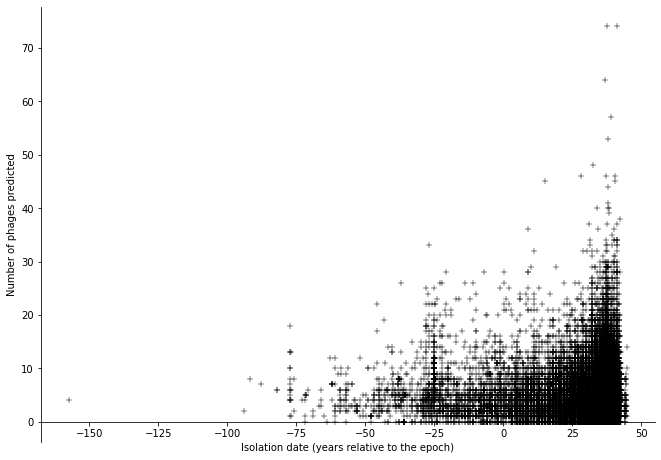

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 8))
ax = sns.scatterplot(x='years_ago', y='Kept', data=phagemeta[phagemeta['years_ago'] != -1], ax=ax, marker='+', color='k')
ax.set_ylabel("Number of phages predicted")
ax.set_xlabel("Isolation date (years relative to the epoch)")
#ax.axhline(y=0, color='k')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')


fig.savefig(f"images/phages_vs_ya.svg")

<AxesSubplot:xlabel='isolation_source', ylabel='Kept'>

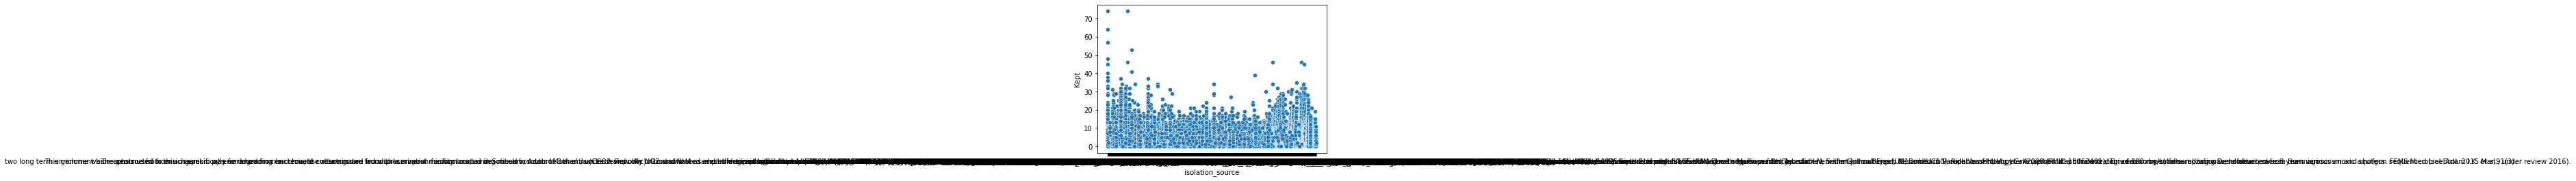

In [31]:
sns.scatterplot(x='isolation_source', y='Kept', data=phagemeta[phagemeta['isolation_source'].notnull()])